# 05 — Comprehensive Cross-Sector Analysis

6-section analysis of cross-sector transient correlations:

1. **Pair Discovery Landscape** — Frequency tiers, cross-sector counts, sector heatmap
2. **Relationship Validation** — 5-test scored framework
3. **Recurring Pairs** — Most consistent co-clustering pairs
4. **Trading Viability** — Baseline vs enhanced backtests
5. **Semiconductor Baseline Comparison** — vs 54% profitable, Sharpe 3.55
6. **Key Findings & Limitations**

**Semiconductor baseline:** 54% profitable, top Sharpe 3.55

In [1]:
import sys, os

project_root = os.path.abspath(os.path.join('..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from screener.analysis import (
    build_pair_registry, run_analysis,
    pair_type_summary, sector_pair_breakdown, generate_report,
    validate_pair_relationship,
)
from screener.enhanced_backtest import (
    run_enhanced_analysis, enhanced_backtest_pair, compute_annualized_sharpe,
)
from trading.trading import (
    walk_forward_backtest, get_daily_prices, compute_noise_adjusted_frequency,
)
from screener.universe import load_cached_universe

%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# Load artifacts
data_dir = os.path.join('..', 'data', 'combined')
_, _, sector_map = load_cached_universe('combined')

with open(os.path.join(data_dir, 'ts_df.pkl'), 'rb') as f:
    ts_df = pickle.load(f)
with open(os.path.join(data_dir, 'cluster_history.pkl'), 'rb') as f:
    cluster_history = pickle.load(f)
with open(os.path.join(data_dir, 'pair_co_cluster_freq.pkl'), 'rb') as f:
    pair_freq = pickle.load(f)

# Load permutation results from notebook 04 if available
perm_path = os.path.join(data_dir, 'permutation_results.pkl')
perm_results = None
if os.path.exists(perm_path):
    with open(perm_path, 'rb') as f:
        perm_results = pickle.load(f)
    print(f"Permutation results loaded: {len(perm_results.get('pair_zscores', {}))} pairs tested")

print(f"Sector map: {len(sector_map)} tickers")
print(f"Total co-clustering pairs: {len(pair_freq):,}")

Permutation results loaded: 3539 pairs tested
Sector map: 142 tickers
Total co-clustering pairs: 7,836


---
## Section 1: Pair Discovery Landscape

How many pairs survive at different noise-adjusted frequency thresholds?
Where do cross-sector pairs appear?

In [3]:
# Build registries at multiple thresholds
thresholds = [0.05, 0.08, 0.10, 0.15]
tier_stats = []

for thresh in thresholds:
    reg = build_pair_registry(
        cluster_history, pair_freq, sector_map=sector_map,
        noise_adj_freq_threshold=thresh,
    )
    n_total = len(reg)
    n_intra = (reg['pair_type'] == 'intra-sector').sum() if 'pair_type' in reg.columns else 0
    n_cross = (reg['pair_type'] == 'cross-sector').sum() if 'pair_type' in reg.columns else 0
    tier_stats.append({
        'threshold': thresh,
        'total_pairs': n_total,
        'intra_sector': int(n_intra),
        'cross_sector': int(n_cross),
    })

df_tiers = pd.DataFrame(tier_stats)
print("Frequency Tier Analysis")
print("=" * 60)
display(df_tiers)

Frequency Tier Analysis


,threshold,total_pairs,intra_sector,cross_sector
0,0.0500,4911,1710,3201
1,0.0800,3643,1442,2201
2,0.1000,3036,1295,1741
3,0.1500,1815,932,883


In [4]:
# Top 15 cross-sector pairs (at lowest threshold to see them)
reg_low = build_pair_registry(
    cluster_history, pair_freq, sector_map=sector_map,
    noise_adj_freq_threshold=0.05,
)
cross = reg_low[reg_low['pair_type'] == 'cross-sector'].copy()

print(f"\nTop 15 Cross-Sector Pairs (threshold=0.05)")
print("=" * 60)
if len(cross) > 0:
    display(cross.head(15)[['Pair', 'noise_adj_freq', 'sector_1', 'sector_2']])
else:
    print("No cross-sector pairs found.")


Top 15 Cross-Sector Pairs (threshold=0.05)


,Pair,noise_adj_freq,sector_1,sector_2
4,APLD-IREN,0.9082,Technology,Financial Services
10,APLD-CIFR,0.8761,Technology,Financial Services
13,CRWV-HUT,0.8636,Technology,Financial Services
18,CIFR-CRWV,0.8354,Financial Services,Technology
20,BE-SNDK,0.8250,Industrials,Technology
21,APLD-HUT,0.8125,Technology,Financial Services
23,APLD-BE,0.8000,Technology,Industrials
26,CRWV-RIOT,0.7794,Technology,Financial Services
28,BE-IREN,0.7634,Industrials,Financial Services
30,BE-CIFR,0.7500,Industrials,Financial Services


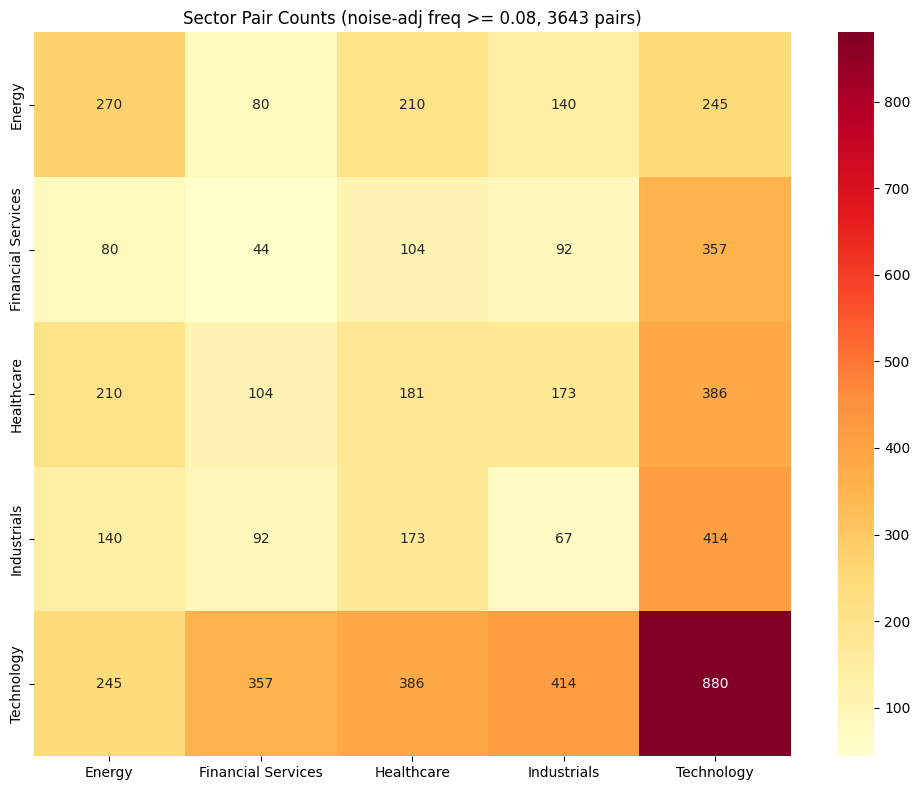


Pair type breakdown at 0.08 threshold:
pair_type
cross-sector    2201
intra-sector    1442


In [5]:
# Sector combination heatmap
reg_08 = build_pair_registry(
    cluster_history, pair_freq, sector_map=sector_map,
    noise_adj_freq_threshold=0.08,
)

if 'sector_1' in reg_08.columns and len(reg_08) > 0:
    # Build symmetric count matrix
    sectors = sorted(set(reg_08['sector_1'].unique()) | set(reg_08['sector_2'].unique()))
    heatmap_data = pd.DataFrame(0, index=sectors, columns=sectors)
    for _, r in reg_08.iterrows():
        s1, s2 = r['sector_1'], r['sector_2']
        heatmap_data.loc[s1, s2] += 1
        if s1 != s2:
            heatmap_data.loc[s2, s1] += 1

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
    ax.set_title(f'Sector Pair Counts (noise-adj freq >= 0.08, {len(reg_08)} pairs)')
    plt.tight_layout()
    plt.show()

    print(f"\nPair type breakdown at 0.08 threshold:")
    print(reg_08['pair_type'].value_counts().to_string())

---
## Section 2: Relationship Validation

5-test scored framework: ADF | Half-Life | Hurst | Variance Ratio | Rolling Correlation

- **Strong (4-5/5):** High-confidence pair
- **Moderate (3/5):** Likely valid relationship
- **Weak (2/5):** Marginal evidence
- **Fail (<2/5):** Insufficient evidence

In [6]:
# Run full analysis with 5-test validation at 0.08 threshold
registry = reg_08.copy()
print(f"Running 5-test validation on {len(registry)} pairs...")
results = run_analysis(registry, ts_df)

print(f"\nDone. {len(results)} pairs tested.")

Running 5-test validation on 3643 pairs...
  Testing pair 1/3643: PBR-PBR-A
  Testing pair 20/3643: CRGY-PTEN
  Testing pair 40/3643: IREN-MARA


  Testing pair 60/3643: CNQ-SU
  Testing pair 80/3643: BMY-PFE


  Testing pair 100/3643: ABT-BSX
  Testing pair 120/3643: APLD-RUN
  Testing pair 140/3643: PLTR-RUN


  Testing pair 160/3643: CRM-PATH
  Testing pair 180/3643: APA-HAL
  Testing pair 200/3643: MDT-MRK


  Testing pair 220/3643: LUV-TEVA
  Testing pair 240/3643: AMD-PLTR
  Testing pair 260/3643: PBR-XOM


  Testing pair 280/3643: FLEX-NVDA
  Testing pair 300/3643: MU-VNET
  Testing pair 320/3643: AFRM-VRT


  Testing pair 340/3643: ABT-CVS
  Testing pair 360/3643: CTRA-DVN
  Testing pair 380/3643: DDOG-PYPL


  Testing pair 400/3643: PFE-ZTS
  Testing pair 420/3643: MU-SHOP
  Testing pair 440/3643: AMAT-FLEX


  Testing pair 460/3643: ARM-VNET
  Testing pair 480/3643: BSX-JNJ
  Testing pair 500/3643: AFRM-ENPH


  Testing pair 520/3643: LUV-UAL
  Testing pair 540/3643: AMD-DELL
  Testing pair 560/3643: VRT-XYZ


  Testing pair 580/3643: CRM-PYPL
  Testing pair 600/3643: CPRT-CWAN
  Testing pair 620/3643: ADT-FAST


  Testing pair 640/3643: APA-VG
  Testing pair 660/3643: CTRA-PBR-A
  Testing pair 680/3643: CSCO-INFY


  Testing pair 700/3643: HPQ-TXN
  Testing pair 720/3643: BE-MU
  Testing pair 740/3643: ARM-STM


  Testing pair 760/3643: GILD-MRK
  Testing pair 780/3643: ASX-OWL
  Testing pair 800/3643: AFRM-MCHP


  Testing pair 820/3643: OWL-TSM
  Testing pair 840/3643: FLEX-RKT
  Testing pair 860/3643: DDOG-TSM


  Testing pair 880/3643: CSCO-CTRA
  Testing pair 900/3643: BAX-VTRS
  Testing pair 920/3643: CRDO-MU


  Testing pair 940/3643: AAPL-VTRS
  Testing pair 960/3643: CNH-NOW
  Testing pair 980/3643: CNH-QXO


  Testing pair 1000/3643: NVO-ZTS
  Testing pair 1020/3643: HPQ-NOW
  Testing pair 1040/3643: COIN-ON


  Testing pair 1060/3643: ANET-RKT
  Testing pair 1080/3643: BSX-SHEL
  Testing pair 1100/3643: OWL-SNDK


  Testing pair 1120/3643: CNH-HPE
  Testing pair 1140/3643: CVS-GE
  Testing pair 1160/3643: FTNT-PATH


  Testing pair 1180/3643: AMAT-DAL
  Testing pair 1200/3643: ASX-WDC
  Testing pair 1220/3643: TOST-XYZ


  Testing pair 1240/3643: GEN-GLW
  Testing pair 1260/3643: ANET-CRDO
  Testing pair 1280/3643: ABBV-KMI


  Testing pair 1300/3643: DELL-SNDK
  Testing pair 1320/3643: CVS-TEVA
  Testing pair 1340/3643: JCI-LUV


  Testing pair 1360/3643: INTC-OWL
  Testing pair 1380/3643: DVN-XOM
  Testing pair 1400/3643: ADT-JNJ


  Testing pair 1420/3643: SHOP-WDC
  Testing pair 1440/3643: FAST-KMI
  Testing pair 1460/3643: CRBG-QXO


  Testing pair 1480/3643: MCHP-SLB
  Testing pair 1500/3643: CRGY-CWAN
  Testing pair 1520/3643: GILD-JCI


  Testing pair 1540/3643: CRBG-INFY
  Testing pair 1560/3643: FAST-WU
  Testing pair 1580/3643: PTEN-XYZ


  Testing pair 1600/3643: NVO-UMC
  Testing pair 1620/3643: AVTR-UMC
  Testing pair 1640/3643: AVGO-MRVL


  Testing pair 1660/3643: MARA-RIG
  Testing pair 1680/3643: BSX-WMB
  Testing pair 1700/3643: SLB-XOM


  Testing pair 1720/3643: GE-ORCL
  Testing pair 1740/3643: ABT-VTRS
  Testing pair 1760/3643: NVDA-WDC


  Testing pair 1780/3643: AAPL-BP
  Testing pair 1800/3643: KMI-MSFT
  Testing pair 1820/3643: INFY-SHEL


  Testing pair 1840/3643: GILD-MSFT
  Testing pair 1860/3643: ADT-AVTR
  Testing pair 1880/3643: ASX-LUV


  Testing pair 1900/3643: CPRT-PBR
  Testing pair 1920/3643: SONY-TXN
  Testing pair 1940/3643: FOLD-MRK


  Testing pair 1960/3643: BKR-KMI
  Testing pair 1980/3643: ASX-TEVA
  Testing pair 2000/3643: ADT-VTRS


  Testing pair 2020/3643: BAX-FTNT
  Testing pair 2040/3643: NOK-STNE
  Testing pair 2060/3643: GEN-PYPL


  Testing pair 2080/3643: GILD-RTX
  Testing pair 2100/3643: SLB-XP
  Testing pair 2120/3643: CRWV-INFY


  Testing pair 2140/3643: INTC-PYPL
  Testing pair 2160/3643: AMD-INTC
  Testing pair 2180/3643: FLEX-XP


  Testing pair 2200/3643: ORCL-QXO
  Testing pair 2220/3643: AMAT-QCOM
  Testing pair 2240/3643: COIN-LRCX


  Testing pair 2260/3643: BE-ZETA
  Testing pair 2280/3643: ADT-SHEL
  Testing pair 2300/3643: CVS-MDT


  Testing pair 2320/3643: AAL-AFRM
  Testing pair 2340/3643: BAX-ERIC
  Testing pair 2360/3643: VG-ZETA


  Testing pair 2380/3643: AMAT-OGN
  Testing pair 2400/3643: GILD-WU
  Testing pair 2420/3643: LUV-WDC


  Testing pair 2440/3643: BAX-PTEN
  Testing pair 2460/3643: EQT-ZTS
  Testing pair 2480/3643: AMD-PATH


  Testing pair 2500/3643: RIOT-VRT
  Testing pair 2520/3643: AFRM-UAL
  Testing pair 2540/3643: MRVL-TEVA


  Testing pair 2560/3643: ARM-WDC
  Testing pair 2580/3643: BMY-CTSH
  Testing pair 2600/3643: IVZ-UNH


  Testing pair 2620/3643: PATH-VTRS
  Testing pair 2640/3643: IVZ-YMM
  Testing pair 2660/3643: AAPL-PANW


  Testing pair 2680/3643: BSX-UMC
  Testing pair 2700/3643: LUV-UMC
  Testing pair 2720/3643: INFY-NVO


  Testing pair 2740/3643: ABT-UMC
  Testing pair 2760/3643: BMY-QXO
  Testing pair 2780/3643: AAL-INTC


  Testing pair 2800/3643: GE-SHEL
  Testing pair 2820/3643: DAL-ENPH
  Testing pair 2840/3643: ERIC-UBER


  Testing pair 2860/3643: BAX-QCOM
  Testing pair 2880/3643: AVGO-XYZ
  Testing pair 2900/3643: CWAN-JNJ


  Testing pair 2920/3643: CVS-INFY
  Testing pair 2940/3643: FTNT-INFY
  Testing pair 2960/3643: CTSH-MSFT


  Testing pair 2980/3643: LUV-RKT
  Testing pair 3000/3643: NOK-RTX
  Testing pair 3020/3643: AAPL-CWAN


  Testing pair 3040/3643: CVX-JNJ
  Testing pair 3060/3643: CARR-ZTS
  Testing pair 3080/3643: JCI-UNH


  Testing pair 3100/3643: ADT-AR
  Testing pair 3120/3643: CWAN-JCI
  Testing pair 3140/3643: APA-IVZ


  Testing pair 3160/3643: DXCM-ON
  Testing pair 3180/3643: PBR-UPS
  Testing pair 3200/3643: AVGO-CNH


  Testing pair 3220/3643: CVX-ERIC
  Testing pair 3240/3643: CWAN-FAST
  Testing pair 3260/3643: PBR-A-UNH


  Testing pair 3280/3643: ASX-SONY
  Testing pair 3300/3643: AVTR-ZTS
  Testing pair 3320/3643: AVTR-DXCM


  Testing pair 3340/3643: APH-DELL
  Testing pair 3360/3643: CPRT-XOM
  Testing pair 3380/3643: MSFT-VTRS


  Testing pair 3400/3643: FTNT-OGN
  Testing pair 3420/3643: CRM-STM
  Testing pair 3440/3643: AVGO-RKT


  Testing pair 3460/3643: BKR-LUV
  Testing pair 3480/3643: CSCO-TXN
  Testing pair 3500/3643: FAST-XP


  Testing pair 3520/3643: FLEX-UBER
  Testing pair 3540/3643: CNH-GLW
  Testing pair 3560/3643: JNJ-PBR


  Testing pair 3580/3643: CRGY-ON
  Testing pair 3600/3643: AFRM-CRGY
  Testing pair 3620/3643: HAL-PFE


  Testing pair 3640/3643: CNH-INTC

Done. 3643 pairs tested.


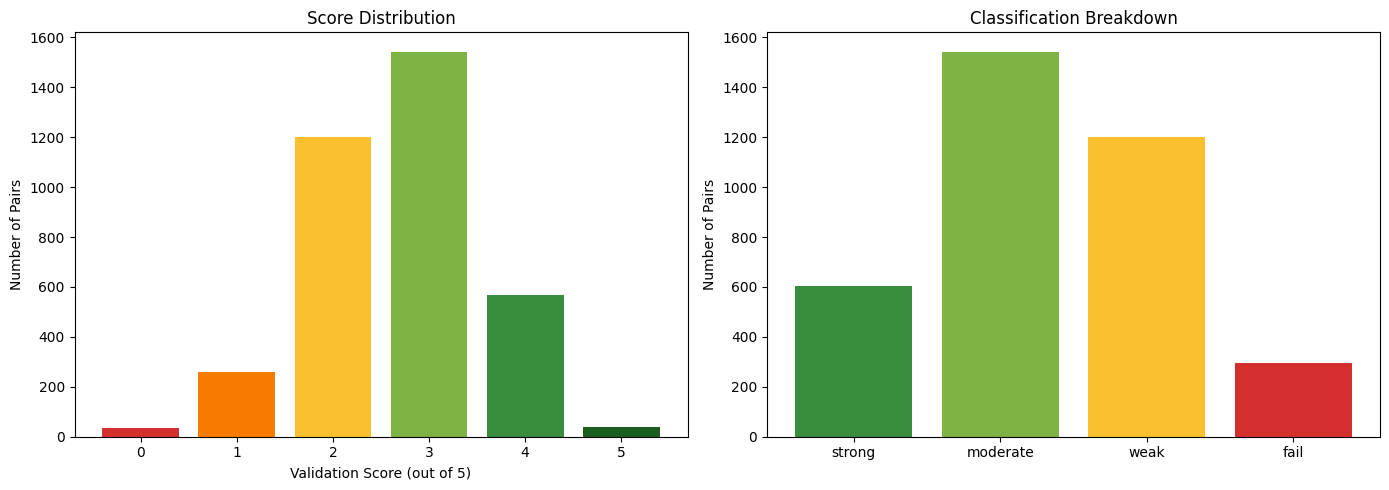

Classification summary:
  Strong    : 605
  Moderate  : 1543
  Weak      : 1200
  Fail      : 295


In [7]:
# Score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of scores
score_counts = results['score'].value_counts().sort_index()
colors = {0: '#d32f2f', 1: '#f57c00', 2: '#fbc02d', 3: '#7cb342', 4: '#388e3c', 5: '#1b5e20'}
bar_colors = [colors.get(s, '#666') for s in score_counts.index]
axes[0].bar(score_counts.index, score_counts.values, color=bar_colors)
axes[0].set_xlabel('Validation Score (out of 5)')
axes[0].set_ylabel('Number of Pairs')
axes[0].set_title('Score Distribution')
axes[0].set_xticks(range(6))

# Classification breakdown
cls_order = ['strong', 'moderate', 'weak', 'fail']
cls_counts = results['classification'].value_counts().reindex(cls_order, fill_value=0)
cls_colors = ['#388e3c', '#7cb342', '#fbc02d', '#d32f2f']
axes[1].bar(cls_counts.index, cls_counts.values, color=cls_colors)
axes[1].set_ylabel('Number of Pairs')
axes[1].set_title('Classification Breakdown')

plt.tight_layout()
plt.show()

print("Classification summary:")
for cls in cls_order:
    n = int((results['classification'] == cls).sum())
    print(f"  {cls.capitalize():10s}: {n}")

Test-by-test pass rates (diagnostic):
  ADF (p<0.10)             : 38.3%  (1395/3643)
  Half-life (5-60d)        : 82.3%  (2998/3643)
  Hurst (<0.5)             : 90.5%  (3296/3643)
  Variance Ratio           : 21.8%  (793/3643)
  Rolling Corr Stability   : 34.7%  (1264/3643)


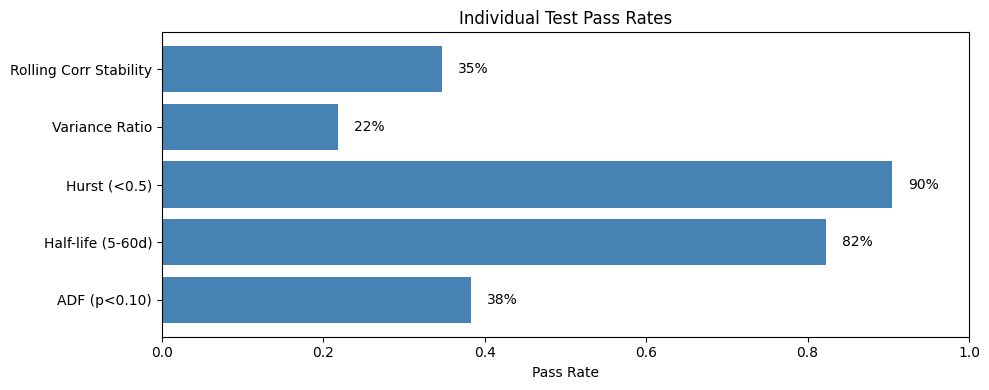

In [8]:
# Test-by-test pass rates
valid = results[results['n_daily_obs'] > 0]
tests = [
    ('adf_passed', 'ADF (p<0.10)'),
    ('hl_passed', 'Half-life (5-60d)'),
    ('hurst_passed', 'Hurst (<0.5)'),
    ('vr_passed', 'Variance Ratio'),
    ('rc_passed', 'Rolling Corr Stability'),
]

print("Test-by-test pass rates (diagnostic):")
print("=" * 50)
test_rates = []
for col, label in tests:
    if col in valid.columns:
        rate = valid[col].mean()
        n_pass = int(valid[col].sum())
        print(f"  {label:25s}: {rate:5.1%}  ({n_pass}/{len(valid)})")
        test_rates.append({'test': label, 'pass_rate': rate, 'n_pass': n_pass})

# Visualize
if test_rates:
    df_rates = pd.DataFrame(test_rates)
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.barh(df_rates['test'], df_rates['pass_rate'], color='steelblue')
    ax.set_xlim(0, 1)
    ax.set_xlabel('Pass Rate')
    ax.set_title('Individual Test Pass Rates')
    for bar, rate in zip(bars, df_rates['pass_rate']):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f'{rate:.0%}', va='center')
    plt.tight_layout()
    plt.show()

In [9]:
# Breakdown by pair type and sector
if 'pair_type' in results.columns:
    print("Score by pair type:")
    print("=" * 50)
    ptype = pair_type_summary(results)
    display(ptype)

    print("\nSector pair breakdown:")
    spb = sector_pair_breakdown(results)
    display(spb)

Score by pair type:


,pair_type,n_pairs,n_strong,n_moderate,n_passed,n_near_miss,avg_score,pass_rate,avg_sharpe,best_sharpe,profitable_frac,avg_noise_adj_freq
0,cross-sector,2201,323,900,323,900,2.6152,0.1468,1.5899,2.5597,0.4080,0.1629
1,intra-sector,1442,282,643,282,643,2.7670,0.1956,1.9457,1.9626,0.4238,0.2284



Sector pair breakdown:


,sector_1,sector_2,n_pairs,n_tradeable,avg_score,avg_noise_adj_freq,avg_sharpe
0,Technology,Technology,880,504,2.6420,0.2110,1.9288
1,Energy,Energy,270,230,3.0889,0.2689,NaN
2,Industrials,Technology,243,155,2.7942,0.1605,2.5597
3,Healthcare,Technology,197,105,2.5736,0.1623,0.5653
4,Technology,Healthcare,189,105,2.6508,0.1489,NaN
5,Technology,Financial Services,183,99,2.5956,0.2077,NaN
6,Healthcare,Healthcare,181,121,2.8564,0.2147,NaN
7,Financial Services,Technology,174,102,2.7069,0.2215,1.6446
8,Technology,Industrials,171,91,2.5673,0.1721,NaN
9,Technology,Energy,123,51,2.4228,0.1508,NaN


In [10]:
# Table of strong + moderate pairs with all test details
tradeable = results[results['score'] >= 3].copy()
print(f"\nStrong + Moderate pairs: {len(tradeable)}")
print("=" * 80)

detail_cols = ['pair', 'score', 'classification', 'noise_adj_freq',
               'adf_pval', 'half_life_days', 'hurst', 'variance_ratio', 'rolling_corr_stability']
if 'pair_type' in tradeable.columns:
    detail_cols = ['pair_type'] + detail_cols

if len(tradeable) > 0:
    display(tradeable.sort_values(['score', 'noise_adj_freq'], ascending=[False, False])[detail_cols])
else:
    print("No pairs scored >= 3.")


Strong + Moderate pairs: 2148


,pair_type,pair,score,classification,noise_adj_freq,adf_pval,half_life_days,hurst,variance_ratio,rolling_corr_stability
7,intra-sector,AAL-DAL,5,strong,0.8940,0.0372,5.3897,0.4087,0.8703,0.8912
14,intra-sector,AAL-UAL,5,strong,0.8624,0.0532,6.0097,0.4384,0.8672,0.9359
124,intra-sector,STM-TXN,5,strong,0.4777,0.0950,7.4114,0.4166,0.8845,0.7343
256,intra-sector,MRVL-WDC,5,strong,0.3750,0.0468,5.9998,0.4299,0.8691,0.8176
496,intra-sector,APH-AVGO,5,strong,0.2925,0.0994,5.9906,0.2910,0.8356,0.5434
...,...,...,...,...,...,...,...,...,...,...
3633,intra-sector,ANET-SONY,3,moderate,0.0800,0.0872,7.7127,0.3120,0.9709,0.0146
3634,cross-sector,SONY-V,3,moderate,0.0800,0.1896,9.1280,0.3574,0.8691,0.4622
3636,cross-sector,AVGO-GE,3,moderate,0.0800,0.0004,3.5832,0.2194,0.9155,0.7866
3639,cross-sector,CNH-INTC,3,moderate,0.0800,0.0206,5.6088,0.3268,0.9251,0.3831


---
## Section 3: Recurring Pairs

Which pairs co-cluster most frequently? Are recurring pairs also well-validated?

In [11]:
# Pairs with highest co-cluster frequency
print("Top 20 pairs by noise-adjusted frequency:")
print("=" * 60)

top_freq = results.nlargest(20, 'noise_adj_freq')
freq_cols = ['pair', 'noise_adj_freq', 'raw_freq', 'score', 'classification']
if 'pair_type' in top_freq.columns:
    freq_cols = ['pair_type'] + freq_cols
display(top_freq[freq_cols])

Top 20 pairs by noise-adjusted frequency:


,pair_type,pair,noise_adj_freq,raw_freq,score,classification
0,intra-sector,PBR-PBR-A,0.9913,0.5709,4,strong
1,intra-sector,CIFR-HUT,0.9385,0.1677,2,weak
2,intra-sector,CIFR-IREN,0.9125,0.1457,4,strong
3,intra-sector,MARA-RIOT,0.9123,0.1557,4,strong
4,cross-sector,APLD-IREN,0.9082,0.0888,3,moderate
5,intra-sector,HUT-MARA,0.9020,0.1377,3,moderate
6,intra-sector,ALAB-CRDO,0.8974,0.0699,2,weak
7,intra-sector,AAL-DAL,0.8940,0.3283,5,strong
8,intra-sector,APLD-CRWV,0.8831,0.0679,2,weak
9,intra-sector,CIFR-RIOT,0.8769,0.1138,3,moderate


In [12]:
# Formation counts and durations from cached artifacts
dur_path = os.path.join(data_dir, 'df_durations.pkl')
form_path = os.path.join(data_dir, 'df_formations.pkl')

if os.path.exists(dur_path) and os.path.exists(form_path):
    with open(dur_path, 'rb') as f:
        df_durations = pickle.load(f)
    with open(form_path, 'rb') as f:
        df_formations = pickle.load(f)

    # Build pair key from formations
    if 'Pair' in df_formations.columns:
        form_counts = df_formations['Pair'].value_counts().head(20)
        print(f"\nTop 20 pairs by formation count:")
        print(form_counts.to_string())

    if 'Pair' in df_durations.columns and 'Duration_Hours' in df_durations.columns:
        avg_dur = df_durations.groupby('Pair')['Duration_Hours'].mean().sort_values(ascending=False).head(20)
        print(f"\nTop 20 pairs by avg formation duration (hours):")
        print(avg_dur.to_string())
else:
    print("Formation/duration artifacts not found — skipping.")


Top 20 pairs by formation count:
Pair
KMI-WMB      47
DVN-PR       47
MARA-RIOT    43
BP-SHEL      43
CVE-PR       42
APA-CRGY     42
CNQ-SU       40
AR-EQT       40
HUT-IREN     40
CIFR-HUT     40
COP-DVN      39
AAL-UAL      39
CVE-DVN      38
SHEL-SU      38
SHEL-XOM     38
CNQ-DVN      37
AAL-DAL      37
CNQ-CVE      37
HAL-SLB      37
COP-CVE      36

Top 20 pairs by avg formation duration (hours):
Pair
PBR-PBR-A   286.5500
AAL-VRT     235.0000
IVZ-OGN     122.0000
AMAT-CRDO   122.0000
ALAB-AMAT   122.0000
APH-GEN     121.0000
CVX-XOM     119.5714
DAL-UAL     113.2069
UAL-VRT     103.0000
STNE-TXN     98.0000
AVGO-NOK     98.0000
BKR-CVS      98.0000
DDOG-OGN     98.0000
CNC-OXY      97.0000
BE-CSX       93.0000
AVGO-COP     92.0000
AVGO-OXY     92.0000
DVN-OXY      85.1515
AAL-DAL      83.8649
FTNT-NVO     83.5000


In [13]:
# Statistically significant pairs from permutation test
if perm_results is not None:
    pair_zscores = perm_results.get('pair_zscores', {})
    sig_pairs = {p for p, z in pair_zscores.items() if z > 1.96}
    print(f"Statistically significant pairs (permutation Z > 1.96): {len(sig_pairs)}")

    # Overlap: significant AND validated (score >= 3)
    validated_pairs = set()
    for _, r in tradeable.iterrows():
        validated_pairs.add((r['ticker_a'], r['ticker_b']))
        validated_pairs.add(r['pair'])

    overlap = []
    for pair_key in sig_pairs:
        if isinstance(pair_key, tuple):
            pair_str = f"{pair_key[0]}-{pair_key[1]}"
        else:
            pair_str = pair_key
        if pair_str in validated_pairs or pair_key in validated_pairs:
            overlap.append(pair_str)

    print(f"Overlap (significant + score >= 3): {len(overlap)}")
    if overlap:
        print("  Pairs:", sorted(overlap))
else:
    print("No permutation results available.")

Statistically significant pairs (permutation Z > 1.96): 940


Overlap (significant + score >= 3): 569
  Pairs: ['AAL-ALAB', 'AAL-AMAT', 'AAL-ASX', 'AAL-CRBG', 'AAL-DAL', 'AAL-HPQ', 'AAL-JBLU', 'AAL-LRCX', 'AAL-LUV', 'AAL-MU', 'AAL-QXO', 'AAL-UAL', 'AAL-XYZ', 'AAPL-CSCO', 'AAPL-HAL', 'AAPL-HPE', 'AAPL-UPS', 'ABBV-BAX', 'ABBV-BMY', 'ABBV-CVS', 'ABBV-JNJ', 'ABBV-MDT', 'ABBV-PFE', 'ABT-BMY', 'ABT-BSX', 'ABT-EQT', 'ABT-ERIC', 'ABT-FAST', 'ABT-GEN', 'ABT-JNJ', 'ABT-MRK', 'ABT-NOK', 'ABT-UPS', 'ABT-YMM', 'ADT-AVTR', 'ADT-BKR', 'ADT-BMY', 'ADT-CPRT', 'ADT-CSCO', 'ADT-CSX', 'ADT-CTSH', 'ADT-CVS', 'ADT-CVX', 'ADT-ERIC', 'ADT-FAST', 'ADT-FTNT', 'ADT-JCI', 'ADT-MDT', 'ADT-NOK', 'ADT-PBR', 'ADT-PFE', 'ADT-PYPL', 'ADT-V', 'ADT-VTRS', 'ADT-ZTS', 'ALAB-DAL', 'ALAB-ZETA', 'AMAT-DELL', 'AMAT-HAL', 'AMAT-TSM', 'AMD-ARM', 'AMD-DELL', 'AMD-MRVL', 'AMD-NVDA', 'ANET-FLEX', 'ANET-PLTR', 'ANET-SHOP', 'ANET-SONY', 'ANET-TSM', 'APA-CRGY', 'APA-DVN', 'APA-PBR', 'APA-PBR-A', 'APA-PR', 'APA-RIG', 'APH-AVGO', 'APH-DXCM', 'APH-GE', 'APH-GLW', 'APH-HPE', 'APH-LRCX', 'APH-MSFT', 

---
## Section 4: Trading Viability

Compare baseline (static z=2.0, OLS, no costs) vs enhanced (optimized z, Kalman, 10bps costs).

In [14]:
# Run enhanced backtests on top 50 tradeable pairs (score >= 3) by noise-adj freq
# Full enhanced backtest is expensive (grid search per pair), so we cap at 50.
tradeable_reg = registry[registry['Pair'].isin(tradeable['pair'])].copy()

if len(tradeable_reg) > 50:
    print(f"Capping enhanced backtests: {len(tradeable_reg)} tradeable -> top 50 by noise_adj_freq")
    tradeable_reg = tradeable_reg.nlargest(50, 'noise_adj_freq')

if len(tradeable_reg) > 0:
    print(f"Running enhanced backtests on {len(tradeable_reg)} tradeable pairs...")
    enhanced_results = run_enhanced_analysis(tradeable_reg, ts_df, cost_per_trade=0.001)
    print(f"Done. {len(enhanced_results)} pairs backtested.")
else:
    enhanced_results = pd.DataFrame()
    print("No tradeable pairs to backtest.")

Capping enhanced backtests: 2148 tradeable -> top 50 by noise_adj_freq
Running enhanced backtests on 50 tradeable pairs...
  Enhanced backtest 1/50: PBR-PBR-A


  Enhanced backtest 10/50: DAL-UAL


  Enhanced backtest 20/50: CVX-XOM


  Enhanced backtest 30/50: AAL-JBLU


  Enhanced backtest 40/50: MARA-SMCI


  Enhanced backtest 50/50: IREN-RUN
Done. 50 pairs backtested.


In [15]:
# Side-by-side comparison table
if len(enhanced_results) > 0:
    compare_cols = ['pair']
    if 'pair_type' in enhanced_results.columns:
        compare_cols.append('pair_type')
    compare_cols += [
        'baseline_n_trades', 'baseline_pnl', 'baseline_sharpe', 'baseline_ann_sharpe',
        'opt_entry_z', 'opt_lookback',
        'enhanced_n_trades', 'enhanced_pnl', 'enhanced_sharpe', 'enhanced_ann_sharpe',
        'kalman_n_trades', 'kalman_pnl', 'kalman_sharpe', 'kalman_ann_sharpe',
    ]
    available_cols = [c for c in compare_cols if c in enhanced_results.columns]

    print("Baseline vs Enhanced vs Kalman:")
    print("=" * 80)
    display(enhanced_results[available_cols].sort_values('enhanced_pnl', ascending=False))

Baseline vs Enhanced vs Kalman:


,pair,pair_type,baseline_n_trades,baseline_pnl,baseline_sharpe,baseline_ann_sharpe,opt_entry_z,opt_lookback,enhanced_n_trades,enhanced_pnl,enhanced_sharpe,enhanced_ann_sharpe,kalman_n_trades,kalman_pnl,kalman_sharpe,kalman_ann_sharpe
42,AFRM-ZETA,cross-sector,2,18.5662,2.7486,2.5925,2.0000,20.0000,2,18.5642,2.7483,2.5925,2,18.9116,2.7601,2.5938
18,IREN-RIOT,intra-sector,1,6.7679,NaN,1.9394,1.0000,20.0000,5,13.8156,0.9960,3.0954,5,3.9710,0.3283,1.3474
37,ARM-SMCI,intra-sector,3,8.7443,0.4178,1.2896,2.0000,10.0000,4,10.7247,0.3031,1.1195,4,24.6025,0.7617,2.3588
3,APLD-IREN,cross-sector,2,10.3973,7.3098,2.7374,2.0000,20.0000,2,10.3953,7.3084,2.7374,2,8.8942,3.4628,2.6521
41,COP-CVE,intra-sector,3,6.6462,0.5225,1.5513,1.7500,20.0000,5,9.2862,0.4481,1.7712,2,0.5845,0.1267,0.3422
30,COP-DVN,intra-sector,2,5.2310,3.4941,2.6540,1.0000,15.0000,6,9.0123,0.9185,3.2568,7,6.3061,0.5356,2.4328
19,CVX-XOM,intra-sector,2,-0.1268,-0.0179,-0.0487,1.7500,15.0000,4,8.9648,2.0052,3.5305,4,8.7912,2.9652,3.7497
4,HUT-MARA,intra-sector,2,-4.9693,-0.3127,-0.8134,1.0000,10.0000,8,6.9906,0.2159,1.1520,7,31.2352,1.0212,3.7397
46,ENPH-RUN,intra-sector,4,13.9548,1.1112,2.9100,2.0000,10.0000,2,5.9329,2.4222,2.5489,4,3.7472,0.2987,1.1044
13,HUT-IREN,intra-sector,2,4.6949,0.5857,1.3810,1.5000,20.0000,3,5.6749,0.2975,0.9525,3,0.9681,0.0842,0.2797


In [16]:
# Strategy comparison summary
if len(enhanced_results) > 0:
    strategies = [
        ('Baseline (z=2.0, OLS, no costs)', 'baseline'),
        ('Enhanced (opt z, OLS, 10bps)', 'enhanced'),
        ('Kalman (opt z, Kalman, 10bps)', 'kalman'),
    ]

    summary_rows = []
    for label, prefix in strategies:
        pnl_col = f'{prefix}_pnl'
        trades_col = f'{prefix}_n_trades'
        wr_col = f'{prefix}_win_rate'
        sharpe_col = f'{prefix}_sharpe'
        ann_col = f'{prefix}_ann_sharpe'
        dd_col = f'{prefix}_max_dd'

        if pnl_col not in enhanced_results.columns:
            continue

        valid = enhanced_results[enhanced_results[trades_col] > 0]
        summary_rows.append({
            'Strategy': label,
            'Pairs w/ trades': len(valid),
            'Avg trades': valid[trades_col].mean() if len(valid) else 0,
            'Avg PnL': valid[pnl_col].mean() if len(valid) else np.nan,
            'Profitable %': (valid[pnl_col] > 0).mean() if len(valid) else np.nan,
            'Avg win rate': valid[wr_col].mean() if len(valid) else np.nan,
            'Avg Sharpe': valid[sharpe_col].dropna().mean() if len(valid) else np.nan,
            'Avg Ann Sharpe': valid[ann_col].dropna().mean() if len(valid) else np.nan,
        })

    df_summary = pd.DataFrame(summary_rows)
    print("Strategy Comparison Summary:")
    print("=" * 80)
    display(df_summary)

Strategy Comparison Summary:


,Strategy,Pairs w/ trades,Avg trades,Avg PnL,Profitable %,Avg win rate,Avg Sharpe,Avg Ann Sharpe
0,"Baseline (z=2.0, OLS, no costs)",50,1.9000,0.1230,0.5400,0.5867,0.7287,0.3567
1,"Enhanced (opt z, OLS, 10bps)",49,2.7959,0.1662,0.5714,0.6272,1.0921,0.4941
2,"Kalman (opt z, Kalman, 10bps)",50,2.6200,0.8949,0.6400,0.6461,0.6067,0.6887


In [17]:
# Walk-forward on top 10 enhanced pairs
if len(enhanced_results) > 0:
    top_enhanced = enhanced_results.dropna(subset=['enhanced_pnl']).nlargest(10, 'enhanced_pnl')

    wf_results = []
    for _, row in top_enhanced.iterrows():
        daily_a = get_daily_prices(row['ticker_a'], ts_df)
        daily_b = get_daily_prices(row['ticker_b'], ts_df)

        # Use optimized params if available
        ez = row.get('opt_entry_z', 2.0)
        lb = int(row.get('opt_lookback', 20)) if not np.isnan(row.get('opt_lookback', np.nan)) else 20
        xz = row.get('opt_exit_z', 0.5)
        if np.isnan(ez): ez = 2.0
        if np.isnan(xz): xz = 0.5

        wf = walk_forward_backtest(daily_a, daily_b, entry_z=ez, exit_z=xz, lookback=lb)
        if wf is not None:
            wf_entry = {
                'pair': row['pair'],
                'n_splits': wf['n_splits'],
                'avg_sharpe': wf['avg_sharpe'],
                'std_sharpe': wf['std_sharpe'],
                'avg_pnl': wf['avg_pnl'],
                'total_trades': wf['total_trades'],
            }
            if 'pair_type' in row.index:
                wf_entry['pair_type'] = row['pair_type']
            wf_results.append(wf_entry)

    df_wf = pd.DataFrame(wf_results)
    if not df_wf.empty:
        print("Walk-Forward Results (top 10 enhanced pairs):")
        print("=" * 60)
        display(df_wf.sort_values('avg_sharpe', ascending=False))
    else:
        print("No pairs qualified for walk-forward validation.")

Walk-Forward Results (top 10 enhanced pairs):


,pair,n_splits,avg_sharpe,std_sharpe,avg_pnl,total_trades,pair_type
0,AFRM-ZETA,5,2.0700,1.1263,10.6759,11,cross-sector
8,ENPH-RUN,5,1.8183,0.8183,2.2686,6,intra-sector
1,IREN-RIOT,5,0.7401,0.7544,6.4639,12,intra-sector
4,COP-CVE,5,0.4545,0.5743,4.3869,16,intra-sector
9,HUT-IREN,5,0.2282,0.8099,-0.1307,11,intra-sector
7,HUT-MARA,5,0.2235,0.7775,6.8196,31,intra-sector
6,CVX-XOM,5,0.0838,0.6980,-3.5822,11,intra-sector
3,APLD-IREN,5,0.0711,0.8522,-0.0372,8,cross-sector
5,COP-DVN,5,0.0417,0.5561,0.8453,23,intra-sector
2,ARM-SMCI,5,-0.5383,0.3070,-8.7125,11,intra-sector


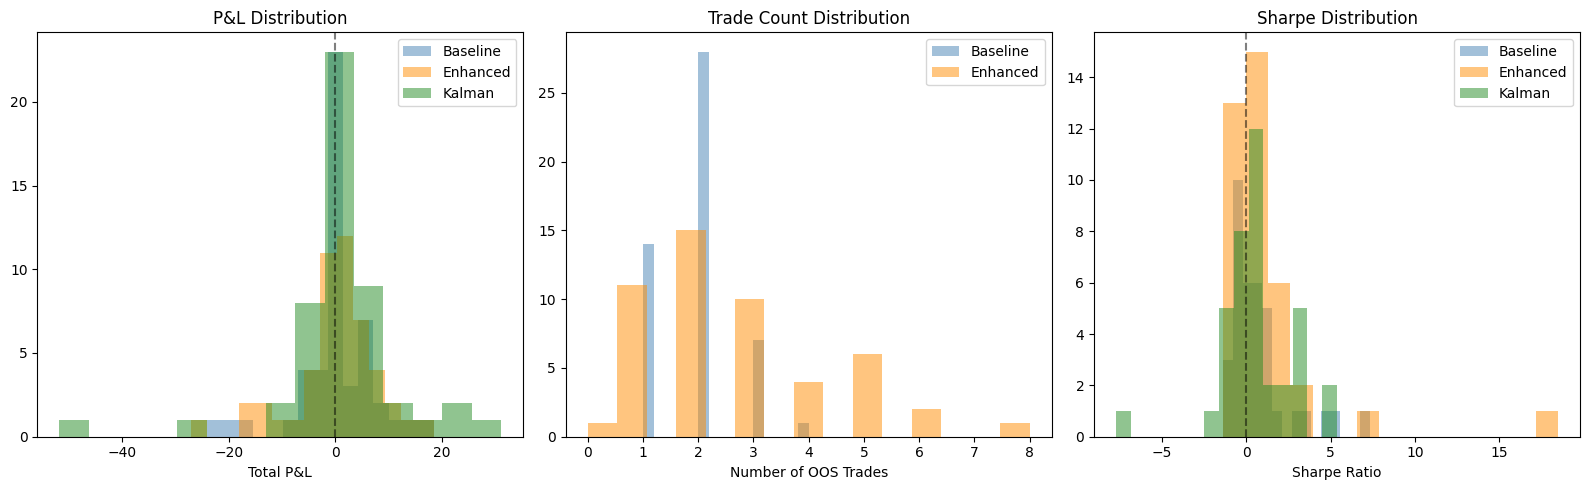

In [18]:
# Distribution plots
if len(enhanced_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # P&L distributions
    for prefix, label, color in [
        ('baseline', 'Baseline', 'steelblue'),
        ('enhanced', 'Enhanced', 'darkorange'),
        ('kalman', 'Kalman', 'forestgreen'),
    ]:
        col = f'{prefix}_pnl'
        if col in enhanced_results.columns:
            vals = enhanced_results[col].dropna()
            if len(vals) > 0:
                axes[0].hist(vals, bins=15, alpha=0.5, label=label, color=color)
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.5)
    axes[0].set_title('P&L Distribution')
    axes[0].set_xlabel('Total P&L')
    axes[0].legend()

    # Trade counts
    for prefix, label, color in [
        ('baseline', 'Baseline', 'steelblue'),
        ('enhanced', 'Enhanced', 'darkorange'),
    ]:
        col = f'{prefix}_n_trades'
        if col in enhanced_results.columns:
            vals = enhanced_results[col].dropna()
            if len(vals) > 0:
                axes[1].hist(vals, bins=15, alpha=0.5, label=label, color=color)
    axes[1].set_title('Trade Count Distribution')
    axes[1].set_xlabel('Number of OOS Trades')
    axes[1].legend()

    # Sharpe comparison
    for prefix, label, color in [
        ('baseline', 'Baseline', 'steelblue'),
        ('enhanced', 'Enhanced', 'darkorange'),
        ('kalman', 'Kalman', 'forestgreen'),
    ]:
        col = f'{prefix}_sharpe'
        if col in enhanced_results.columns:
            vals = enhanced_results[col].dropna()
            if len(vals) > 0:
                axes[2].hist(vals, bins=15, alpha=0.5, label=label, color=color)
    axes[2].axvline(0, color='black', linestyle='--', alpha=0.5)
    axes[2].set_title('Sharpe Distribution')
    axes[2].set_xlabel('Sharpe Ratio')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

---
## Section 5: Semiconductor Baseline Comparison

Semiconductor baseline: 54% profitable, top Sharpe 3.55

In [19]:
semi_baseline = {'profitable_frac': 0.54, 'top_sharpe': 3.55}

print("=" * 60)
print("COMPARISON vs SEMICONDUCTOR BASELINE")
print("=" * 60)
print(f"Baseline: {semi_baseline['profitable_frac']:.0%} profitable, top Sharpe {semi_baseline['top_sharpe']:.2f}")

# Screened universe results
if len(tradeable) > 0:
    profitable = (tradeable['total_pnl'] > 0).mean()
    valid_s = tradeable['sharpe'].dropna()
    top_sharpe = valid_s.max() if len(valid_s) > 0 else np.nan
    avg_sharpe = valid_s.mean() if len(valid_s) > 0 else np.nan

    print(f"\nScreened universe (5-test validation, threshold=0.08):")
    print(f"  Total pairs tested: {len(results)}")
    print(f"  Tradeable (score>=3): {len(tradeable)}")
    print(f"  Profitable: {profitable:.0%}" if len(tradeable) > 0 else "  Profitable: N/A")
    print(f"  Top Sharpe: {top_sharpe:.2f}" if np.isfinite(top_sharpe) else "  Top Sharpe: N/A")
    print(f"  Avg Sharpe: {avg_sharpe:.2f}" if np.isfinite(avg_sharpe) else "  Avg Sharpe: N/A")

    # Intra vs cross comparison
    if 'pair_type' in tradeable.columns:
        print()
        for ptype in ['intra-sector', 'cross-sector']:
            sub = tradeable[tradeable['pair_type'] == ptype]
            if len(sub) > 0:
                p = (sub['total_pnl'] > 0).mean()
                vs = sub['sharpe'].dropna()
                ts = vs.max() if len(vs) > 0 else np.nan
                avg_s = vs.mean() if len(vs) > 0 else np.nan
                print(f"  {ptype}:")
                print(f"    Pairs: {len(sub)}, Profitable: {p:.0%}")
                if np.isfinite(ts):
                    print(f"    Top Sharpe: {ts:.2f}, Avg Sharpe: {avg_s:.2f}")

    # Enhanced comparison
    if len(enhanced_results) > 0:
        enh_valid = enhanced_results[enhanced_results['enhanced_n_trades'] > 0]
        if len(enh_valid) > 0:
            enh_profitable = (enh_valid['enhanced_pnl'] > 0).mean()
            enh_sharpes = enh_valid['enhanced_sharpe'].dropna()
            enh_top = enh_sharpes.max() if len(enh_sharpes) > 0 else np.nan
            print(f"\n  Enhanced strategy (optimized z, 10bps costs):")
            print(f"    Pairs w/ trades: {len(enh_valid)}")
            print(f"    Profitable: {enh_profitable:.0%}")
            if np.isfinite(enh_top):
                print(f"    Top Sharpe: {enh_top:.2f}")
else:
    print("\nNo tradeable pairs to compare.")

COMPARISON vs SEMICONDUCTOR BASELINE
Baseline: 54% profitable, top Sharpe 3.55

Screened universe (5-test validation, threshold=0.08):
  Total pairs tested: 3643
  Tradeable (score>=3): 2148
  Profitable: 41%
  Top Sharpe: 2.56
  Avg Sharpe: 1.73

  intra-sector:
    Pairs: 925, Profitable: 42%
    Top Sharpe: 1.96, Avg Sharpe: 1.95
  cross-sector:
    Pairs: 1223, Profitable: 41%
    Top Sharpe: 2.56, Avg Sharpe: 1.59

  Enhanced strategy (optimized z, 10bps costs):
    Pairs w/ trades: 49
    Profitable: 57%
    Top Sharpe: 18.47


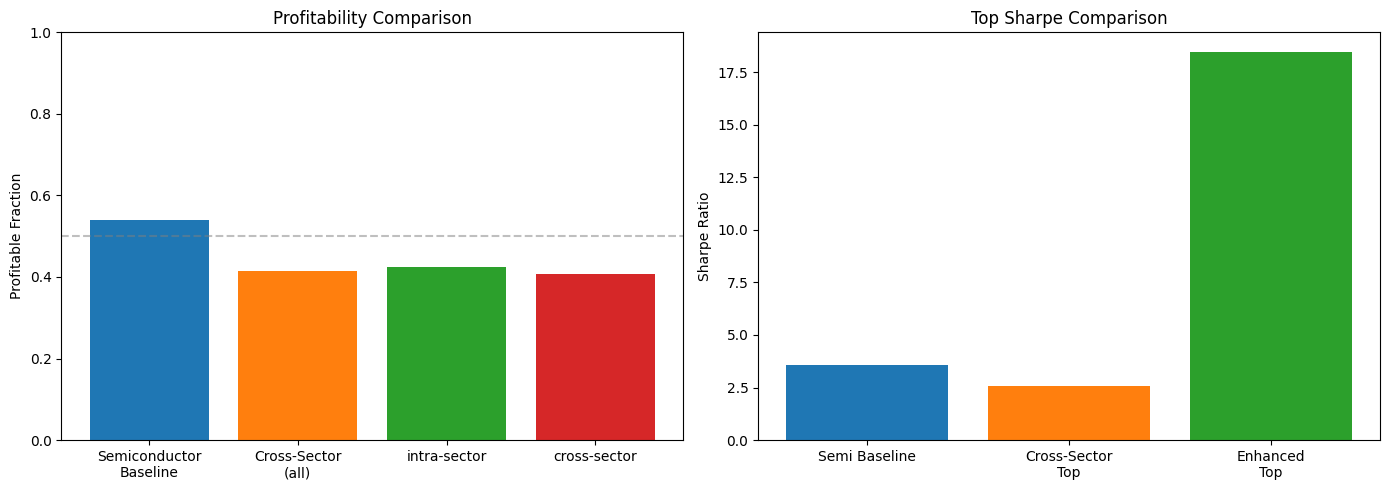

In [20]:
# Visual comparison
if len(tradeable) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Profitability comparison
    labels = ['Semiconductor\nBaseline']
    values_prof = [semi_baseline['profitable_frac']]
    colors_prof = ['#1f77b4']

    overall_prof = (tradeable['total_pnl'] > 0).mean()
    labels.append('Cross-Sector\n(all)')
    values_prof.append(overall_prof)
    colors_prof.append('#ff7f0e')

    if 'pair_type' in tradeable.columns:
        for ptype, color in [('intra-sector', '#2ca02c'), ('cross-sector', '#d62728')]:
            sub = tradeable[tradeable['pair_type'] == ptype]
            if len(sub) > 0:
                labels.append(f'{ptype}')
                values_prof.append((sub['total_pnl'] > 0).mean())
                colors_prof.append(color)

    axes[0].bar(labels, values_prof, color=colors_prof)
    axes[0].set_ylabel('Profitable Fraction')
    axes[0].set_title('Profitability Comparison')
    axes[0].set_ylim(0, 1)
    axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)

    # Sharpe comparison
    labels_s = ['Semi Baseline']
    values_s = [semi_baseline['top_sharpe']]
    colors_s = ['#1f77b4']

    valid_s = tradeable['sharpe'].dropna()
    if len(valid_s) > 0:
        labels_s.append('Cross-Sector\nTop')
        values_s.append(valid_s.max())
        colors_s.append('#ff7f0e')

    if len(enhanced_results) > 0:
        enh_s = enhanced_results['enhanced_sharpe'].dropna()
        if len(enh_s) > 0:
            labels_s.append('Enhanced\nTop')
            values_s.append(enh_s.max())
            colors_s.append('#2ca02c')

    axes[1].bar(labels_s, values_s, color=colors_s)
    axes[1].set_ylabel('Sharpe Ratio')
    axes[1].set_title('Top Sharpe Comparison')

    plt.tight_layout()
    plt.show()

---
## Section 6: Key Findings & Limitations

In [21]:
# Generate full report
report = generate_report(results)
print(report)

CROSS-SECTOR TRANSIENT CORRELATION ANALYSIS
5-Test Scored Validation: ADF | Half-Life | Hurst | Variance Ratio | Rolling Corr
(Sharpe only reported for pairs with >= 5 OOS trades)

--- SCORE DISTRIBUTION ---
Pairs tested:        3643
  Strong    :      605
  Moderate  :      1543
  Weak      :      1200
  Fail      :      295

--- TEST PASS RATES ---
  ADF (p<0.10)             : 38.3% (1395/3643)
  Half-life (5-60d)        : 82.3% (2998/3643)
  Hurst (<0.5)             : 90.5% (3296/3643)
  Variance ratio           : 21.8% (793/3643)
  Rolling corr stability   : 34.7% (1264/3643)

--- LEGACY COMPAT ---
Strong (score>=4):   605
Moderate (score==3): 1543

--- INTRA-SECTOR vs CROSS-SECTOR ---
   pair_type  n_pairs  n_strong  n_moderate  n_passed  n_near_miss  avg_score  pass_rate  avg_sharpe  best_sharpe  profitable_frac  avg_noise_adj_freq
cross-sector     2201       323         900       323          900      2.615      0.147       1.590        2.560            0.408               0.163

In [22]:
# Summary table
summary_data = {
    'Metric': [
        'Total pairs at 0.08 threshold',
        'Intra-sector pairs',
        'Cross-sector pairs',
        'Strong (score 4-5)',
        'Moderate (score 3)',
        'Weak (score 2)',
        'Fail (score <2)',
        'ADF pass rate',
        'Half-life pass rate',
        'Hurst pass rate',
        'Variance ratio pass rate',
        'Rolling corr pass rate',
    ],
    'Value': [
        len(results),
        int((results.get('pair_type', pd.Series()) == 'intra-sector').sum()),
        int((results.get('pair_type', pd.Series()) == 'cross-sector').sum()),
        int((results['classification'] == 'strong').sum()),
        int((results['classification'] == 'moderate').sum()),
        int((results['classification'] == 'weak').sum()),
        int((results['classification'] == 'fail').sum()),
        f"{valid['adf_passed'].mean():.0%}" if 'adf_passed' in valid.columns else 'N/A',
        f"{valid['hl_passed'].mean():.0%}" if 'hl_passed' in valid.columns else 'N/A',
        f"{valid['hurst_passed'].mean():.0%}" if 'hurst_passed' in valid.columns else 'N/A',
        f"{valid['vr_passed'].mean():.0%}" if 'vr_passed' in valid.columns else 'N/A',
        f"{valid['rc_passed'].mean():.0%}" if 'rc_passed' in valid.columns else 'N/A',
    ],
}
df_final_summary = pd.DataFrame(summary_data)
display(df_final_summary)

print("\nLimitations:")
print("- Data covers ~10 months of hourly data; longer periods needed for robustness")
print("- OOS window is ~68 days — short for reliable Sharpe estimation")
print("- Transaction costs are simplified (flat 10bps); real costs vary by asset")
print("- Kalman filter requires tuning of transition covariance (currently fixed at 0.01)")
print("- Cross-sector pairs have lower frequency by construction — fewer co-clustering events")

,Metric,Value
0,Total pairs at 0.08 threshold,3643
1,Intra-sector pairs,1442
2,Cross-sector pairs,2201
3,Strong (score 4-5),605
4,Moderate (score 3),1543
5,Weak (score 2),1200
6,Fail (score <2),295
7,ADF pass rate,N/A
8,Half-life pass rate,N/A
9,Hurst pass rate,N/A



Limitations:
- Data covers ~10 months of hourly data; longer periods needed for robustness
- OOS window is ~68 days — short for reliable Sharpe estimation
- Transaction costs are simplified (flat 10bps); real costs vary by asset
- Kalman filter requires tuning of transition covariance (currently fixed at 0.01)
- Cross-sector pairs have lower frequency by construction — fewer co-clustering events


In [23]:
# Save all results
with open(os.path.join(data_dir, 'analysis_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

with open(os.path.join(data_dir, 'report.txt'), 'w') as f:
    f.write(report)

if len(enhanced_results) > 0:
    with open(os.path.join(data_dir, 'enhanced_results.pkl'), 'wb') as f:
        pickle.dump(enhanced_results, f)

if 'df_wf' in dir() and not df_wf.empty:
    with open(os.path.join(data_dir, 'walk_forward_results.pkl'), 'wb') as f:
        pickle.dump(df_wf, f)

print("All results saved.")

All results saved.
